## **과대적합/ 과소적합 방지**

이전 Binary Classification의 IMDB 데이터셋 로드하기

In [1]:
from keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17465344/17464789 [==============================] - 0s 0us/step


In [2]:
train_data.shape

(25000,)

### 데이터 준비

In [5]:
# 정수 시퀀스를 이진 행렬로 인코딩하기
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
  results = np.zeros((len(sequences), dimension))
  for i, sequence in enumerate(sequences):
    results[i, sequence]=1 # results[i] 에서 특정 인덱스 위치를 1로 만듦
  return results 

# 벡터로 변환
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)


In [6]:
# 레이블도 벡터로 변환
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

### 신경망 모델 만들기
- 16개의 hidden unit을 가진 2개의 hidden layer
- 리뷰 감정을 스칼라 값의 예측으로 출력하는 3번째 층

### 1. 네트워크 크기 축소

In [3]:
from keras import models
from keras import layers

# 원래 모델
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# 축소된 모델
smodel = models.Sequential()
smodel.add(layers.Dense(6, activation='relu', input_shape = (10000, )))
smodel.add(layers.Dense(6, activation='relu'))
smodel.add(layers.Dense(1, activation='sigmoid'))

In [4]:
from keras import optimizers
from keras import losses
from keras import metrics

# 원래 모델 컴파일
model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

# 축소된 모델 컴파일
smodel.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

### 훈련 검증

In [7]:
# validation set 준비
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

In [8]:
history1 = model.fit(partial_x_train,
                    partial_y_train,
                    epochs = 20,
                    batch_size=512,
                    validation_data = (x_val, y_val),
                    verbose = 0)

In [9]:
history2 = smodel.fit(partial_x_train,
                    partial_y_train,
                    epochs = 20,
                    batch_size=512,
                    validation_data = (x_val, y_val),
                    verbose = 0)

In [11]:
# model.fit()이 반환하는 history객체 확인
history_dict = history1.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

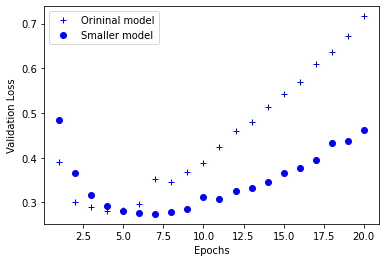

In [21]:
# 검증 손실 그리기
import matplotlib.pyplot as plt

history_dict1 = history1.history
history_dict2 = history2.history
loss1 = history_dict1['val_loss']
loss2 = history_dict2['val_loss']

epochs = range(1, len(loss1)+1)

plt.plot(epochs, loss1, 'b+', label='Orininal model')  
plt.plot(epochs, loss2, 'bo', label='Smaller model') 
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()

plt.show()

축소된 네트워크가 더 나중에 과적합됨

### 2. 네트워크 크기 확장

In [17]:
# 확장된 모델
bmodel = models.Sequential()
bmodel.add(layers.Dense(1024, activation='relu', input_shape = (10000, )))
bmodel.add(layers.Dense(1024, activation='relu'))
bmodel.add(layers.Dense(1, activation='sigmoid'))

# 확장된 모델 컴파일
bmodel.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

In [18]:
history3 = bmodel.fit(partial_x_train,
                    partial_y_train,
                    epochs = 20,
                    batch_size=512,
                    validation_data = (x_val, y_val),
                    verbose = 0)

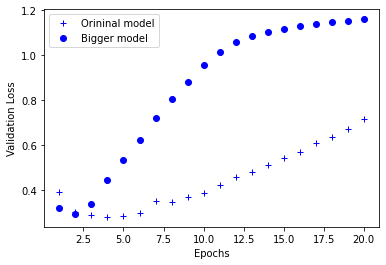

In [22]:
# 검증 손실 그리기
import matplotlib.pyplot as plt

history_dict3 = history3.history
loss3 = history_dict3['val_loss']

epochs = range(1, len(loss1)+1)

plt.plot(epochs, loss1, 'b+', label='Orininal model')  
plt.plot(epochs, loss3, 'bo', label='Bigger model') 
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()

plt.show()

* 용량이 큰 네트워크는 첫 번째 에폭 이후 거의 바로 과대적합이 시작
* 검증 손실도 매우 불안정

## 3. 가중치 규제 추가

In [25]:
# Regularizer 구현은 이렇게 한다.
from keras import regularizers

rmodel = models.Sequential()
rmodel.add(layers.Dense(16, activation='relu', kernel_regularizer= regularizers.l2(0.001), input_shape = (10000, )))
rmodel.add(layers.Dense(16, activation='relu', kernel_regularizer= regularizers.l2(0.001)))
rmodel.add(layers.Dense(1, activation='sigmoid'))

rmodel.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])

history4 = rmodel.fit(partial_x_train, partial_y_train, batch_size=128, epochs= 20, validation_data=(x_val, y_val), verbose=0)

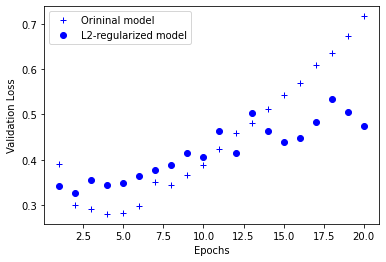

In [26]:
# 검증 손실 그리기
import matplotlib.pyplot as plt

history_dict4 = history4.history
loss4 = history_dict4['val_loss']

epochs = range(1, len(loss1)+1)

plt.plot(epochs, loss1, 'b+', label='Orininal model')  
plt.plot(epochs, loss4, 'bo', label='L2-regularized model') 
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()

plt.show()

## 4. 드롭아웃

In [27]:
rmodel = models.Sequential()
rmodel.add(layers.Dense(16, activation='relu', kernel_regularizer= regularizers.l2(0.001), input_shape = (10000, )))
rmodel.add(layers.Dropout(0.5))
rmodel.add(layers.Dense(16, activation='relu', kernel_regularizer= regularizers.l2(0.001)))
rmodel.add(layers.Dropout(0.5))
rmodel.add(layers.Dense(1, activation='sigmoid'))


rmodel.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])

history5 = rmodel.fit(partial_x_train, partial_y_train, batch_size=128, epochs= 20, validation_data=(x_val, y_val), verbose=0)

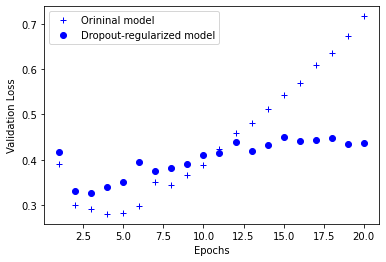

In [29]:
# 검증 손실 그리기
import matplotlib.pyplot as plt

history_dict5 = history5.history
loss5 = history_dict5['val_loss']

epochs = range(1, len(loss1)+1)

plt.plot(epochs, loss1, 'b+', label='Orininal model')  
plt.plot(epochs, loss5, 'bo', label='Dropout-regularized model') 
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()

plt.show()